In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

496
494
498
493
495
497
490
499
212
492


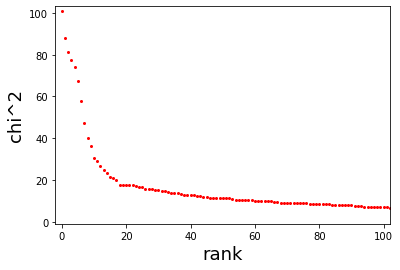

In [2]:
N = 100
M = 500
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 3/4)
    b[i] = np.random.binomial(n[i], 3/4)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
for i in range(10):
    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, stats, marker="o", markersize=2, color = "red", linestyle = "None")
#plt.axhline(23.0, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2", fontsize = 18)
fig.savefig("stats_small.png")
fig.savefig("fig/stats-small.eps")

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

def OMPCL(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    
    for i in range(K):
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMPCL(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def accuracy(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    correct = np.zeros(4)
    for j in range(10):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        pri_comp_rank = rankdata(-pri_comp_data)
        #print(pri_comp_rank[0:20])
        #print(g[0:20])
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        pri_complap_rank = rankdata(-pri_complap_data)
        #print(pri_complap_rank[0:20])
        #print(g[0:20])
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        pri_lap_rank = rankdata(-pri_lap_data)
        #print(pri_lap_rank[0:20])
        #print(g[0:20])
        
        pri_exp_rank = exp_mec(g, deltag, m, K, epsilon)
        #print(pri_exp_rank[0:20])
        #print(g[0:20])
        
        for i in range(K):
            if pri_comp_rank[i] <= K:
                correct[0] += 1
            if pri_complap_rank[i] <= K:
                correct[1] += 1
            if pri_lap_rank[i] <= K:
                correct[2] += 1
            if pri_exp_rank[i] < K:
                correct[3] += 1
    
    acc = correct/(K*10)
    return acc

In [12]:
def calc_RE(pri_data, K, M):
    RE = 0
    pri_rank = rankdata(-pri_data)
    for i in range(K):
        for j in range(M):
            if pri_rank[j] == i + 1:
                RE += math.fabs(j-i)
                break
    RE /= K
    return RE

In [13]:
def calc_RE_exp(pri_data, K):
    RE = 0
    for i in range(K):
        RE += math.fabs(pri_data[i] - i)
    RE /= K
    return RE

In [14]:
def RankError(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    RE = np.zeros(4)
    for j in range(10):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        RE[0] += calc_RE(pri_comp_data, K, m)
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        RE[1] += calc_RE(pri_complap_data, K, m)
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        RE[2] += calc_RE(pri_lap_data, K, m)
        
        pri_exp_data = exp_mec(g, deltag, m, K, epsilon)
        RE[3] += calc_RE_exp(pri_exp_data, K)
    RE /= 10
        
    return RE

[[2.328e+02 4.200e+00 2.733e+02 2.679e+02]
 [1.541e+02 4.300e+00 2.283e+02 1.617e+02]
 [2.642e+02 4.700e+00 2.692e+02 2.318e+02]
 [2.751e+02 4.700e+00 6.920e+01 1.058e+02]
 [1.934e+02 3.800e+00 2.200e+00 4.000e-01]
 [1.957e+02 5.300e+00 3.000e-01 2.000e-01]]
[[2.005e+02 4.700e+00 3.120e+02 2.198e+02]
 [2.032e+02 3.300e+00 3.060e+02 3.176e+02]
 [1.935e+02 4.900e+00 2.624e+02 1.490e+02]
 [9.100e+01 3.400e+00 1.800e+00 8.190e+01]
 [1.676e+02 4.600e+00 3.000e-01 1.100e+00]
 [1.947e+02 3.600e+00 3.000e-01 1.100e+00]]
[[178.3   3.7 228.6 231.2]
 [204.3   4.5 201.7 253.9]
 [206.8   6.7 183.9 230.7]
 [270.8   4.1  42.7  30.9]
 [180.5   2.9   1.    0.5]
 [163.1   3.    0.4   0.3]]
[[2.089e+02 5.300e+00 2.720e+02 1.742e+02]
 [1.795e+02 4.600e+00 2.438e+02 2.855e+02]
 [1.653e+02 4.300e+00 1.616e+02 2.005e+02]
 [2.005e+02 3.500e+00 1.364e+02 3.880e+01]
 [1.911e+02 3.800e+00 9.000e-01 1.900e+00]
 [1.867e+02 2.600e+00 3.000e-01 1.000e-01]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[187.    4.6 227.4 258.4]
 [197.    4.5 237.9 182.1]
 [188.9   3.8 152.4 175. ]
 [163.1   3.3  74.6  61.6]
 [190.1   4.5  22.7   1.1]
 [136.2   3.7   0.3   0.3]]


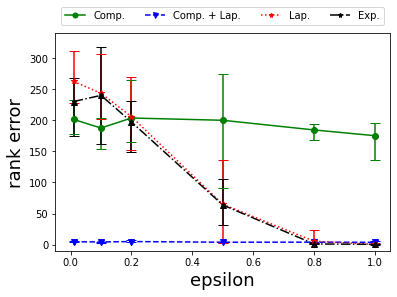

In [15]:
eta = 10
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
ss = determineS(n,d,psi,eta)
kk = int(np.floor(ss*math.log(n/ss)))
    
phiphi = BernoulliMatrix(kk,n)
AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 340)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=1.png")
fig.savefig("fig/RE_small_K=1.eps")

[[189.5         25.9        236.33333333 221.        ]
 [192.66666667   4.         263.5        243.46666667]
 [207.1          5.         246.43333333 260.6       ]
 [180.13333333  35.66666667 175.43333333 212.2       ]
 [178.5         23.1        196.13333333 171.76666667]
 [209.93333333   3.03333333 127.6        154.36666667]]
[[190.9         10.16666667 240.93333333 253.8       ]
 [191.33333333  14.83333333 185.76666667 179.6       ]
 [228.53333333   3.63333333 289.16666667 296.76666667]
 [212.23333333  20.63333333 263.36666667 158.8       ]
 [224.73333333   4.16666667 169.63333333 160.73333333]
 [192.23333333   4.03333333 100.7        162.73333333]]
[[204.43333333   3.4        202.46666667 244.66666667]
 [212.23333333  18.53333333 239.23333333 230.2       ]
 [176.7          4.         215.4        219.        ]
 [167.2          4.53333333 221.46666667 220.86666667]
 [184.13333333  16.66666667 247.43333333 207.2       ]
 [188.16666667  35.66666667 137.46666667 182.33333333]]
[[237.3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[239.56666667  31.03333333 221.03333333 269.13333333]
 [176.5         17.9        233.46666667 245.56666667]
 [204.2          9.96666667 244.2        205.9       ]
 [206.33333333  22.         182.76666667 227.93333333]
 [190.83333333  16.86666667 217.33333333 219.23333333]
 [199.5         22.86666667 165.96666667 149.16666667]]


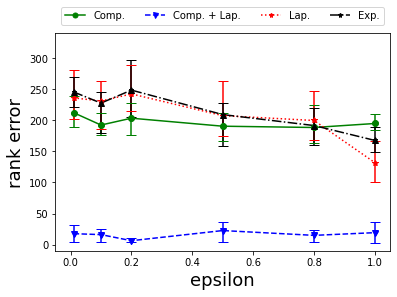

In [16]:
eta = 10
s = 10

K = 3

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 340)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=3.png")
fig.savefig("fig/RE_small_K=3.eps")

[[194.68  43.08 280.92 241.82]
 [190.18  54.88 239.98 261.44]
 [210.42  44.34 235.04 244.08]
 [197.72  44.2  210.3  253.92]
 [193.    33.06 229.86 201.16]
 [151.86  24.6  182.32 193.66]]
[[200.5   74.2  214.24 248.08]
 [176.54  85.02 266.78 265.72]
 [198.72  49.7  232.92 210.12]
 [193.24  26.8  232.94 272.44]
 [176.1   33.42 196.28 210.68]
 [183.42  52.34 178.8  229.56]]
[[227.28  15.4  249.4  283.5 ]
 [188.6   24.94 234.58 254.98]
 [202.82  58.1  258.22 231.92]
 [204.84  62.9  255.46 229.4 ]
 [175.62  81.18 228.44 223.48]
 [203.52  58.94 200.88 211.92]]
[[197.38  22.32 262.98 253.68]
 [188.98  37.52 246.64 231.96]
 [184.98  96.26 237.2  235.3 ]
 [206.24  23.98 232.36 220.06]
 [197.28  71.06 216.32 246.24]
 [198.78  53.86 201.02 249.56]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[196.6   87.22 248.58 216.18]
 [222.92  41.1  256.36 285.72]
 [200.34  86.18 240.34 261.46]
 [188.06  36.24 248.5  277.96]
 [189.2   38.72 187.88 238.04]
 [188.14  47.98 245.1  215.64]]


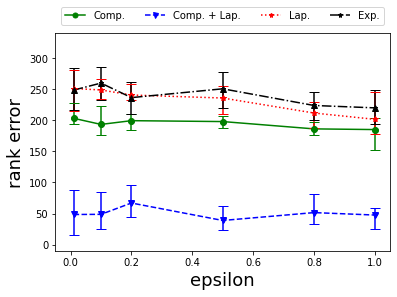

In [17]:
eta = 10
s = 10

K = 5

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 340)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=5.png")
fig.savefig("fig/RE_small_K=5.eps")

[[178.21 147.79 266.92 279.19]
 [206.74 123.52 215.69 250.7 ]
 [209.99 156.24 244.96 267.01]
 [206.81 146.82 230.41 238.83]
 [195.53 167.83 249.75 244.2 ]
 [192.72 121.8  219.48 208.62]]
[[204.79 150.23 263.35 245.32]
 [172.96 152.95 228.75 242.44]
 [187.63 136.1  250.67 257.82]
 [205.36 143.96 242.29 240.04]
 [208.05 127.69 217.21 229.39]
 [217.56 144.44 239.05 230.8 ]]
[[172.78 143.34 227.27 267.86]
 [191.58 157.08 266.91 225.56]
 [192.96 130.86 213.02 217.42]
 [202.05 123.74 233.21 230.66]
 [199.71 143.98 214.31 237.48]
 [176.82 137.04 213.56 211.3 ]]
[[182.34 163.49 251.53 225.35]
 [181.12 139.32 215.29 241.21]
 [208.34 153.86 230.24 239.77]
 [201.09 136.01 255.16 218.95]
 [193.61 117.23 222.59 217.8 ]
 [189.58 114.93 205.59 226.08]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[210.22 129.94 221.69 246.05]
 [173.4  155.55 260.73 251.91]
 [205.79 159.44 231.01 252.08]
 [202.08 130.67 241.9  232.58]
 [218.03 131.47 230.82 244.68]
 [198.86 107.99 224.58 222.05]]


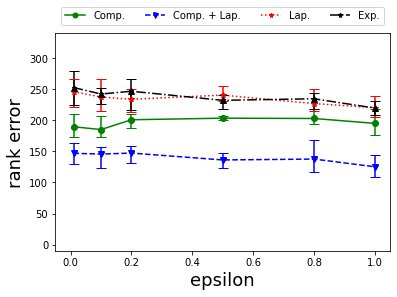

In [18]:
eta = 10
s = 10

K = 10

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 340)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=10.png")
fig.savefig("fig/RE_small_K=10.eps")